# Ensemble Learning with Traditional ML Models (Using K-Fold Cross Validation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import f1_score
import optuna
import os
import secrets

/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_40160/3762919683.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = "data/Regular_processed/With_Ordinal_Encoding/Pos_and_Neg/"
X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
X_valid = np.load(os.path.join(DATA_DIR, "X_valid.npy"))
y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
y_valid = np.load(os.path.join(DATA_DIR, "y_valid.npy"))
X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))

for arr in [X_train, X_valid, y_train, y_valid, X_test]:
    print(arr.shape)

(988, 35)
(247, 35)
(988,)
(247,)
(824, 35)


# Performing K-Fold Splitting

In [3]:
X_total = np.concatenate((X_train, X_valid), axis=0)
y_total = np.concatenate((y_train, y_valid), axis=0)
print(f"X_total: {X_total.shape}\ny_total: {y_total.shape}")

X_total: (1235, 35)
y_total: (1235,)


In [6]:
from sklearn.model_selection import KFold

split_rand_seed = secrets.randbelow(2**32 - 1)
print(f"Random Seed used for K-Fold Cross Validation is: {split_rand_seed}")
kf = KFold(n_splits=5, random_state=split_rand_seed, shuffle=True)

X_train_list = []
X_valid_list = []
y_train_list = []
y_valid_list = []
train_idx_list = []
valid_idx_list = []

for train_idx, valid_idx in kf.split(X_total):
    X_train_fold, X_valid_fold = X_total[train_idx], X_total[valid_idx]
    y_train_fold, y_valid_fold = y_total[train_idx], y_total[valid_idx]

    X_train_list.append(X_train_fold)
    X_valid_list.append(X_valid_fold)
    y_train_list.append(y_train_fold)
    y_valid_list.append(y_valid_fold)

    train_idx_list.append(train_idx)
    valid_idx_list.append(valid_idx)

print(f"Shape of each fold\nX_train_fold = {X_train_list[0].shape}\nX_valid_fold = {X_valid_list[0].shape}\ny_train_list = {y_train_list[0].shape}\ny_valid_list = {y_valid_list[0].shape}")

Random Seed used for K-Fold Cross Validation is: 1988056231
Shape of each fold
X_train_fold = (988, 35)
X_valid_fold = (247, 35)
y_train_list = (988,)
y_valid_list = (247,)


# Get Submission Model Utils

In [15]:
def save_submission_file(model, X_test, save_dir, save_filename):
    test_preds = model.predict(X_test)

    PRED_CATEGORIES = ['died', 'euthanized', 'lived']
    pred_list = [PRED_CATEGORIES[el] for el in test_preds]

    submission_df = pd.DataFrame()
    df_test_raw = pd.read_csv("data/test.csv")
    submission_df['id'] = df_test_raw['id']
    submission_df['outcome'] = pred_list

    submission_df.to_csv(os.path.join(save_dir, save_filename), index=False)

# Loading Traditional ML Models

### Random Forest

In [7]:
average = lambda a_list: sum(a_list) / len(a_list)
argmax = lambda a_list: a_list.index(max(a_list))

In [8]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    random_forest_classifier = RandomForestClassifier(max_depth=3, random_state=123, criterion='entropy', n_estimators=12)
    random_forest_classifier.fit(X_train_fold, y_train_fold)
    random_forest_classifiers_list.append(random_forest_classifier)
    train_preds = random_forest_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = random_forest_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")

Train F1 Scores: [0.6842105263157895, 0.6852226720647774, 0.7004048582995951, 0.6720647773279352, 0.7105263157894737]; Avg = 0.6904858299595142
Valid F1 Scores: [0.6882591093117408, 0.6558704453441295, 0.6356275303643725, 0.6923076923076923, 0.631578947368421]; Avg = 0.6607287449392713
Best Fold = 3


In [12]:
def objective(trial):
    # Suggest values for the hyperparameters using a trial object.
    rf_criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy', 'log_loss'])
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 7, log=True)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 2, 50, log=True)
    rf_random_seed = trial.suggest_int('rf_random_seed', 1, (2**32 - 1), log=True)
    
    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]

        random_forest_classifier = RandomForestClassifier(max_depth=rf_max_depth, random_state=rf_random_seed, criterion=rf_criterion, n_estimators=rf_n_estimators)
        random_forest_classifier.fit(X_train_fold, y_train_fold)
        train_preds = random_forest_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = random_forest_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)
    
    return average(valid_f1_list)  # - abs((train_f1_score - valid_f1_score)/7)

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-04-24 17:48:51,932] A new study created in memory with name: no-name-dd597580-24aa-457d-bdc9-d148dbc62053
[I 2024-04-24 17:48:52,111] Trial 0 finished with value: 0.6890688259109312 and parameters: {'rf_criterion': 'entropy', 'rf_max_depth': 4, 'rf_n_estimators': 48, 'rf_random_seed': 60}. Best is trial 0 with value: 0.6890688259109312.
[I 2024-04-24 17:48:52,133] Trial 1 finished with value: 0.6008097165991904 and parameters: {'rf_criterion': 'log_loss', 'rf_max_depth': 2, 'rf_n_estimators': 4, 'rf_random_seed': 469296848}. Best is trial 0 with value: 0.6890688259109312.
[I 2024-04-24 17:48:52,167] Trial 2 finished with value: 0.6591093117408906 and parameters: {'rf_criterion': 'gini', 'rf_max_depth': 6, 'rf_n_estimators': 6, 'rf_random_seed': 32343}. Best is trial 0 with value: 0.6890688259109312.
[I 2024-04-24 17:48:52,194] Trial 3 finished with value: 0.6566801619433199 and parameters: {'rf_criterion': 'entropy', 'rf_max_depth': 4, 'rf_n_estimators': 5, 'rf_random_seed': 3}

In [13]:
print(f"Best Trial\nValid Foldwise Averaged Micro Averaged F1 Score: {study.best_trial.values}\nHyperParameters = {study.best_trial.params}")

Best Trial
Valid Foldwise Averaged Micro Averaged F1 Score: [0.7068825910931174]
HyperParameters = {'rf_criterion': 'entropy', 'rf_max_depth': 7, 'rf_n_estimators': 37, 'rf_random_seed': 1963}


In [14]:
random_forest_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    random_forest_classifier = RandomForestClassifier(max_depth=7, random_state=1963, criterion='entropy', n_estimators=37)
    random_forest_classifier.fit(X_train_fold, y_train_fold)
    random_forest_classifiers_list.append(random_forest_classifier)
    train_preds = random_forest_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = random_forest_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")

Train F1 Scores: [0.8390688259109311, 0.8360323886639676, 0.8390688259109311, 0.8087044534412956, 0.832995951417004]; Avg = 0.831174089068826
Valid F1 Scores: [0.6923076923076923, 0.728744939271255, 0.6963562753036437, 0.728744939271255, 0.6882591093117408]; Avg = 0.7068825910931174
Best Fold = 1


In [17]:
SAVE_DIR = "submissions/With_Ordinal_Encoding/Pos_and_Neg/K_Fold_Cross_Val"
SAVE_FILE_NAME = "Random_Forest_7_37_entropy_1963.csv"  # MaxDepth_NEstimators_Criterion_RandomState
save_submission_file(model=random_forest_classifiers_list[1], X_test=X_test, save_dir=SAVE_DIR, save_filename=SAVE_FILE_NAME)

### Bernoulli Naive Bayes

In [18]:
from sklearn.naive_bayes import BernoulliNB

naive_bayes_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    naive_bayes_classifier = BernoulliNB()
    naive_bayes_classifier.fit(X_train_fold, y_train_fold)
    naive_bayes_classifiers_list.append(naive_bayes_classifier)
    train_preds = naive_bayes_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = naive_bayes_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")

Train F1 Scores: [0.6680161943319838, 0.6649797570850202, 0.6791497975708503, 0.6659919028340081, 0.6852226720647774]; Avg = 0.6726720647773279
Valid F1 Scores: [0.6923076923076923, 0.7165991902834008, 0.6275303643724697, 0.6720647773279352, 0.6194331983805668]; Avg = 0.665587044534413
Best Fold = 1


### Nearest Centroid

In [19]:
from sklearn.neighbors import NearestCentroid

nearest_centroid_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    nearest_centroid_classifier = NearestCentroid(metric='braycurtis')
    nearest_centroid_classifier.fit(X_train_fold, y_train_fold)
    nearest_centroid_classifiers_list.append(nearest_centroid_classifier)
    train_preds = nearest_centroid_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = nearest_centroid_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")

/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_cent

Train F1 Scores: [0.5991902834008097, 0.604251012145749, 0.6153846153846154, 0.6285425101214575, 0.6174089068825911]; Avg = 0.6129554655870445
Valid F1 Scores: [0.6396761133603239, 0.6032388663967612, 0.5910931174089069, 0.6396761133603239, 0.5991902834008097]; Avg = 0.6145748987854251
Best Fold = 0


/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_cent

In [20]:
def objective(trial):
    # Suggest values for the hyperparameters using a trial object.
    rf_metric = trial.suggest_categorical('rf_metric', ['hamming', 'cosine', 'euclidean', 'yule', 'russellrao', 'jaccard', 'chebyshev',
                                                        'sokalmichener', 'sqeuclidean', 'matching', 'rogerstanimoto', 'nan_euclidean',
                                                        'dice', 'sokalsneath', 'correlation', 'canberra', 'manhattan', 'braycurtis'])
    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]

        nearest_centroid_classifier = NearestCentroid(metric='correlation')
        nearest_centroid_classifier.fit(X_train_fold, y_train_fold)
        train_preds = nearest_centroid_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = nearest_centroid_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)
    
    return average(valid_f1_list)

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-04-24 18:07:49,730] A new study created in memory with name: no-name-5a7f2764-3d4c-4771-9d48-ef78d976a2d7
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/U

In [21]:
print(f"Best Trial\nFoldwise Averaged Valid Micro Averaged F1 Score: {study.best_trial.values}\nHyperParameters = {study.best_trial.params}")

Best Trial
Foldwise Averaged Valid Micro Averaged F1 Score: [0.6307692307692307]
HyperParameters = {'rf_metric': 'sqeuclidean'}


## XGBoost

In [23]:
import xgboost as xgb
from sklearn.model_selection import KFold
import optuna

def objective(trial):
    # Define XGBoost parameters to be optimized
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        'random_state': trial.suggest_int('random_state', 1, (2**32 - 1))
    }

    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]

        xgboost_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3, **params)
        xgboost_classifier.fit(X_train_fold, y_train_fold)
        # xgboost_classifiers_list.append(xgboost_classifier)
        train_preds = xgboost_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = xgboost_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)
    
    # Compute the average F1 score across all folds
    avg_f1_score = average(valid_f1_list)
    
    return avg_f1_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best trial
best_trial = study.best_trial
print(f'Best Trial - F1 Score: {best_trial.value:.4f}')
print(f'Best Hyperparameters: {best_trial.params}')

[I 2024-04-24 18:09:50,746] A new study created in memory with name: no-name-defeab5c-4291-4849-83c8-2cb6b409d98f
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_40160/2059534858.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
[I 2024-04-24 18:09:50,823] Trial 0 finished with value: 0.688259109311741 and parameters: {'n_estimators': 7, 'max_depth': 3, 'learning_rate': 0.29807695492151237, 'random_state': 2007568799}. Best is trial 0 with value: 0.688259109311741.
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_40160/2059534858.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

Best Trial - F1 Score: 0.7134
Best Hyperparameters: {'n_estimators': 19, 'max_depth': 2, 'learning_rate': 0.2574846689960828, 'random_state': 1607338919}


In [24]:
xgboost_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    xgboost_classifier = xgb.XGBClassifier(n_estimators=19, max_depth=2, learning_rate=0.257, objective='multi:softmax', num_class=3, random_state=1607338919)
    xgboost_classifier.fit(X_train_fold, y_train_fold)
    xgboost_classifiers_list.append(xgboost_classifier)
    train_preds = xgboost_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = xgboost_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


Train F1 Scores: [0.7368421052631579, 0.7257085020242915, 0.75, 0.728744939271255, 0.7398785425101214]; Avg = 0.7362348178137651
Valid F1 Scores: [0.6923076923076923, 0.728744939271255, 0.6923076923076923, 0.7489878542510121, 0.6882591093117408]; Avg = 0.7101214574898785
Best Fold = 3


In [30]:
SAVE_DIR = "submissions/With_Ordinal_Encoding/Pos_and_Neg/K_Fold_Cross_Val"
SAVE_FILE_NAME = "XGBoost_2_19_1607338919.csv"  # MaxDepth_NEstimators_RandomState
save_submission_file(model=xgboost_classifiers_list[3], X_test=X_test, save_dir=SAVE_DIR, save_filename=SAVE_FILE_NAME)

## LightGBM

In [26]:
import lightgbm as lgb
from sklearn.metrics import f1_score
import optuna

def objective(trial):
    # Define LightGBM parameters to be optimized
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        'random_state': trial.suggest_int('random_state', 1, (2**32 - 1), log=True)
    }
    
    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]

        # Create LightGBM classifier instance
        lgb_classifier = lgb.LGBMClassifier(objective='multiclass', num_class=3, verbosity=-1, **params)  # verbosity=-1 is to suppress the constant printing
        lgb_classifier.fit(X_train_fold, y_train_fold)
        train_preds = lgb_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = lgb_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)

    return average(valid_f1_list)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best trial
best_trial = study.best_trial
print(f'Best Trial - F1 Score: {best_trial.value:.4f}')
print(f'Best Hyperparameters: {best_trial.params}')

[I 2024-04-24 18:17:14,034] A new study created in memory with name: no-name-1c1156b8-6e02-473c-a657-3486f4fc95fe
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_40160/2658200784.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
[I 2024-04-24 18:17:14,235] Trial 0 finished with value: 0.4987854251012145 and parameters: {'n_estimators': 10, 'max_depth': 4, 'learning_rate': 0.016418138150900957, 'random_state': 1765615691}. Best is trial 0 with value: 0.4987854251012145.
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_40160/2658200784.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) 

Best Trial - F1 Score: 0.7231
Best Hyperparameters: {'n_estimators': 14, 'max_depth': 4, 'learning_rate': 0.3312371944460501, 'random_state': 2559945896}


In [27]:
import lightgbm as lgb
from sklearn.metrics import f1_score

lgb_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    # Create LightGBM classifier instance
    lgb_classifier = lgb.LGBMClassifier(
        n_estimators=14,
        max_depth=4,
        learning_rate=0.3312371944460501,
        objective='multiclass',  # Use 'multiclass' for multi-class classification
        num_class=3,
        random_state=2559945896,
        verbosity=-1   # verbosity=-1 is to suppress the constant printing
    )
    lgb_classifier.fit(X_train_fold, y_train_fold)
    lgb_classifiers_list.append(lgb_classifier)
    train_preds = lgb_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = lgb_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


Train F1 Scores: [0.8502024291497976, 0.8421052631578947, 0.854251012145749, 0.8451417004048583, 0.8451417004048583]; Avg = 0.8473684210526317
Valid F1 Scores: [0.7165991902834008, 0.7368421052631579, 0.7206477732793523, 0.7611336032388664, 0.680161943319838]; Avg = 0.723076923076923
Best Fold = 3


In [29]:
SAVE_DIR = "submissions/With_Ordinal_Encoding/Pos_and_Neg/K_Fold_Cross_Val"
SAVE_FILE_NAME = "LightGBM_4_14_2559945896.csv"  # MaxDepth_NEstimators_RandomState
save_submission_file(model=lgb_classifiers_list[3], X_test=X_test, save_dir=SAVE_DIR, save_filename=SAVE_FILE_NAME)

## HistGradientBoostingClassifier

In [32]:
from sklearn.experimental import enable_hist_gradient_boosting  # Enable experimental HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

def objective(trial):
    # Define hyperparameters to be optimized
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        'max_iter': trial.suggest_int('max_iter', 10, 100, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-6, 1e-3),
        'random_state': trial.suggest_int('random_state', 1, (2**32 - 1), log=True)
    }
    
    # histgb_classifiers_list = []
    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]

        # Create LightGBM classifier instance
        histgb_classifier = HistGradientBoostingClassifier(**params)
        histgb_classifier.fit(X_train_fold, y_train_fold)
        # histgb_classifiers_list.append(histgb_classifier)
        train_preds = histgb_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = histgb_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)

    return average(valid_f1_list)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best trial
best_trial = study.best_trial
print(f'Best Trial - F1 Score: {best_trial.value:.4f}')
print(f'Best Hyperparameters: {best_trial.params}')

/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
[I 2024-04-24 18:39:41,367] A new study created in memory with name: no-name-75ed796a-d331-4554-9c6e-22872a1101e9
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_40160/41667540.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_40160/41667540.py:11: FutureWarning: suggest_loguniform has been deprecated in

Best Trial - F1 Score: 0.7190
Best Hyperparameters: {'learning_rate': 0.2574262422842679, 'max_iter': 16, 'max_depth': 3, 'min_samples_leaf': 11, 'l2_regularization': 0.0004212419957410775, 'random_state': 362310}


In [33]:
# Best Hyperparameters: {'learning_rate': 0.23215781935727378, 'max_iter': 69, 'max_depth': 2, 'min_samples_leaf': 19, 'l2_regularization': 6.605275433883072e-05}
best_params = {
    'learning_rate': study.best_params['learning_rate'],
    'max_iter': study.best_params['max_iter'],
    'max_depth': study.best_params['max_depth'],
    'min_samples_leaf': study.best_params['min_samples_leaf'],
    'l2_regularization': study.best_params['l2_regularization'],
    'random_state': study.best_params['random_state']
}

# # Create and train the HistGradientBoostingClassifier with the best hyperparameters
# best_clf = HistGradientBoostingClassifier(**best_params)
# best_clf.fit(X_train, y_train)

histgb_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    # Create LightGBM classifier instance
    histgb_classifier = HistGradientBoostingClassifier(**best_params)
    histgb_classifier.fit(X_train_fold, y_train_fold)
    histgb_classifiers_list.append(histgb_classifier)
    train_preds = histgb_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = histgb_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)


print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


Train F1 Scores: [0.8117408906882592, 0.8259109311740891, 0.8319838056680162, 0.8228744939271255, 0.8319838056680162]; Avg = 0.8248987854251013
Valid F1 Scores: [0.7165991902834008, 0.7408906882591093, 0.7327935222672065, 0.7449392712550608, 0.659919028340081]; Avg = 0.7190283400809716
Best Fold = 3


In [31]:
SAVE_DIR = "submissions/With_Ordinal_Encoding/Pos_and_Neg/K_Fold_Cross_Val"
SAVE_FILE_NAME = "HistGB_3_16_11.csv" # maxdepth_maxiter_minsampleleafs
save_submission_file(model=histgb_classifiers_list[3], X_test=X_test, save_dir=SAVE_DIR, save_filename=SAVE_FILE_NAME)

NameError: name 'histgb_classifiers_list' is not defined

### Support Vector Classifier

In [25]:
from sklearn import svm

def objective(trial):
    # Define hyperparameters to be optimized
    params = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    }
    if params['kernel'] == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 7)
    
    # histgb_classifiers_list = []
    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]

        # Create LightGBM classifier instance
        svm_classifier = svm.SVC(**params)
        svm_classifier.fit(X_train_fold, y_train_fold)
        # histgb_classifiers_list.append(histgb_classifier)
        train_preds = svm_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = svm_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)

    return average(valid_f1_list)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Get the best trial
best_trial = study.best_trial
print(f'Best Trial - F1 Score: {best_trial.value:.4f}')
print(f'Best Hyperparameters: {best_trial.params}')

[I 2024-04-24 00:54:49,839] A new study created in memory with name: no-name-679d9b90-1de1-4fa5-be7c-e8e3d8cb45e3
[I 2024-04-24 00:54:50,194] Trial 0 finished with value: 0.6639676113360323 and parameters: {'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: 0.6639676113360323.
[I 2024-04-24 00:54:50,504] Trial 1 finished with value: 0.6728744939271255 and parameters: {'kernel': 'linear'}. Best is trial 1 with value: 0.6728744939271255.
[I 2024-04-24 00:54:51,041] Trial 2 finished with value: 0.6850202429149798 and parameters: {'kernel': 'rbf'}. Best is trial 2 with value: 0.6850202429149798.
[I 2024-04-24 00:54:51,351] Trial 3 finished with value: 0.6728744939271255 and parameters: {'kernel': 'linear'}. Best is trial 2 with value: 0.6850202429149798.
[I 2024-04-24 00:54:51,644] Trial 4 finished with value: 0.6251012145748989 and parameters: {'kernel': 'sigmoid'}. Best is trial 2 with value: 0.6850202429149798.
[I 2024-04-24 00:54:52,005] Trial 5 finished with value: 0.60242914

Best Trial - F1 Score: 0.6850
Best Hyperparameters: {'kernel': 'rbf'}


In [27]:
# Best Hyperparameters: 
best_params = {
    'kernel': study.best_params['kernel'],
}
if 'degree' in study.best_params:
    best_params['degree'] = study.best_params['degree']

svm_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    # Create LightGBM classifier instance
    svm_classifier = svm.SVC(**best_params)
    svm_classifier.fit(X_train_fold, y_train_fold)
    svm_classifiers_list.append(svm_classifier)
    train_preds = svm_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = svm_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)


print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


Train F1 Scores: [0.8076923076923077, 0.798582995951417, 0.7854251012145749, 0.7874493927125507, 0.7844129554655871]; Avg = 0.7927125506072874
Valid F1 Scores: [0.6680161943319838, 0.6356275303643725, 0.7125506072874493, 0.7004048582995951, 0.708502024291498]; Avg = 0.6850202429149798
Best Fold = 2


### AdaBoost with SVC
Tried and it worse than SVC and very slow

# Ensemble Learning

In [32]:
estimator_dict = {
    'random_forest': random_forest_classifiers_list,
    'nearest_centroid': nearest_centroid_classifiers_list,
    'bernoulli_naive_bayes': naive_bayes_classifiers_list,
    'XGBoost': xgboost_classifiers_list,
    'lgbm': lgb_classifiers_list,
    'histgb': histgb_classifiers_list,
    'svc': svm_classifiers_list
}
estimators = list(estimator_dict.items())

### Analysis of Models

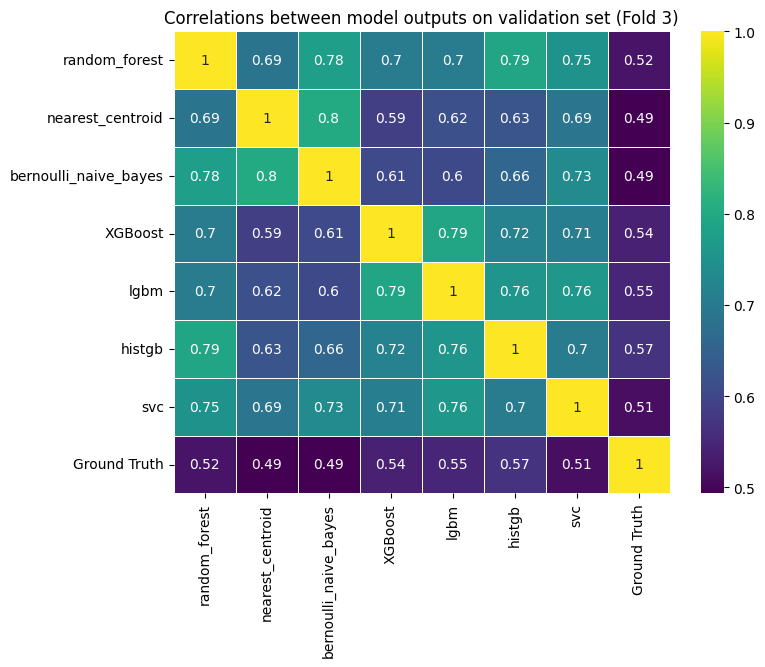

In [33]:
FOLD_NO = 3

val_preds_df = pd.DataFrame()
for name, model in estimators:
    val_preds_df[name] = model[FOLD_NO].predict(X_valid_list[FOLD_NO])
val_preds_df['Ground Truth'] = y_valid_list[FOLD_NO]

# Create the heatmap
plt.figure(figsize = (8,6))
sns.heatmap(val_preds_df.corr(), cmap = 'viridis', annot=True, linewidths=.5)
plt.title(f"Correlations between model outputs on validation set (Fold {FOLD_NO})")
plt.show()

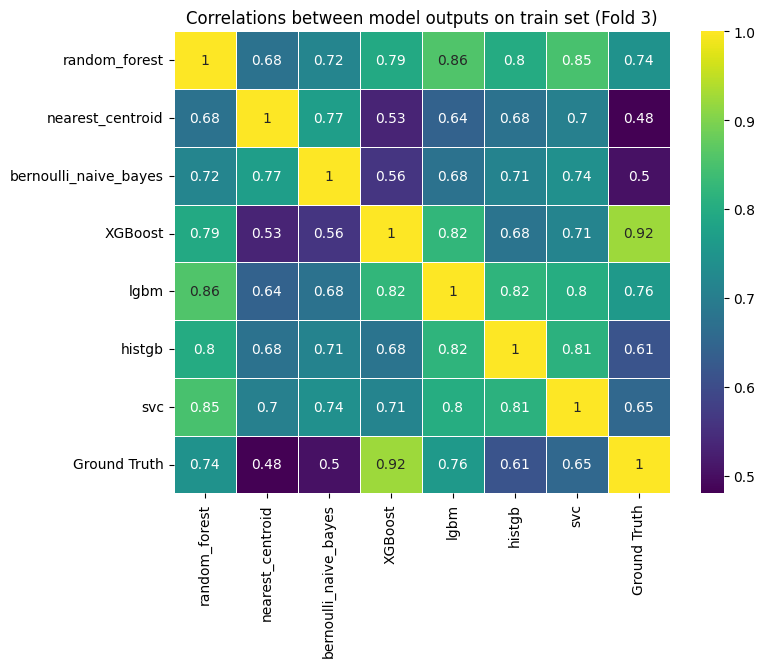

In [34]:
FOLD_NO = 3
train_preds_df = pd.DataFrame()
for name, model in estimators:
    train_preds_df[name] = model[FOLD_NO].predict(X_train_list[FOLD_NO])
train_preds_df['Ground Truth'] = y_train_list[FOLD_NO]

# Create the heatmap
plt.figure(figsize = (8,6))
sns.heatmap(train_preds_df.corr(), cmap = 'viridis', annot=True, linewidths=.5)
plt.title(f"Correlations between model outputs on train set (Fold {FOLD_NO})")
plt.show()

### Voting Classifier

In [36]:
from sklearn.ensemble import VotingClassifier

voting_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]
    fold_wise_estimators = [(k, v[fold_no]) for k, v in estimators]

    voting_classifier = VotingClassifier(estimators=fold_wise_estimators, voting='hard', weights=[3, 2, 1, 1, 1, 1, 1])
    voting_classifier.fit(X_train_fold, y_train_fold)
    voting_classifiers_list.append(voting_classifier)
    train_preds = voting_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = voting_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_cent

Train F1 Scores: [0.8208502024291497, 0.8370445344129555, 0.8157894736842105, 0.812753036437247, 0.8107287449392713]; Avg = 0.8194331983805668
Valid F1 Scores: [0.6842105263157895, 0.6680161943319838, 0.757085020242915, 0.7125506072874493, 0.708502024291498]; Avg = 0.7060728744939271
Best Fold = 2


#### Optimising Voting Classifier Weights 

In [37]:
def objective(trial):
    # Define the range for each weight to optimize
    weights = [trial.suggest_float(f'weight_{i}', 0.1, 10.0) for i in range(len(estimators))]

    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]
        fold_wise_estimators = [(k, v[fold_no]) for k, v in estimators]

        voting_classifier = VotingClassifier(estimators=fold_wise_estimators, voting='hard', weights=weights)
        voting_classifier.fit(X_train_fold, y_train_fold)
        # voting_classifiers_list.append(voting_classifier)
        train_preds = voting_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = voting_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)
    
    return average(valid_f1_list)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # You can adjust the number of trials

# Get the best weights found by Optuna
best_weights = study.best_params
print("Best Weights:", best_weights)

best_weights = [best_weights[f'weight_{i}'] for i in range(len(estimators))]

voting_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]
    fold_wise_estimators = [(k, v[fold_no]) for k, v in estimators]

    voting_classifier = VotingClassifier(estimators=fold_wise_estimators, voting='hard', weights=best_weights)
    voting_classifier.fit(X_train_fold, y_train_fold)
    voting_classifiers_list.append(voting_classifier)
    train_preds = voting_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = voting_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


[I 2024-04-24 01:25:37,740] A new study created in memory with name: no-name-fa4ffabb-9a5a-49f6-b29d-39c2adba9279
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/U

Best Weights: {'weight_0': 1.2046051202192989, 'weight_1': 6.653631990258768, 'weight_2': 2.6404534445923993, 'weight_3': 3.1279611501538223, 'weight_4': 5.496034841762749, 'weight_5': 5.0510075130793135, 'weight_6': 0.26933381875595375}


/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_cent

Train F1 Scores: [0.8208502024291497, 0.8248987854251012, 0.8178137651821862, 0.8157894736842105, 0.8147773279352226]; Avg = 0.8188259109311741
Valid F1 Scores: [0.7125506072874493, 0.6842105263157895, 0.7773279352226721, 0.728744939271255, 0.7246963562753036]; Avg = 0.725506072874494
Best Fold = 2


In [38]:
# Generate Voting Classifier CSV
BEST_FOLD = 2
test_preds = voting_classifiers_list[BEST_FOLD].predict(X_test)

PRED_CATEGORIES = ['died', 'euthanized', 'lived']
pred_list = [PRED_CATEGORIES[el] for el in test_preds]

submission_df = pd.DataFrame()
df_test_raw = pd.read_csv("data/test.csv")
submission_df['id'] = df_test_raw['id']
submission_df['outcome'] = pred_list

submission_df.to_csv("submissions/Without_Ordinal_Encoding/K_Fold_Cross_Val/VotingClassifier_Ensemble_7_RandomForest_7_43_NearestCentroid_NaiveBayes_XGBoost_LGBM_HistGB_SVC_Submission.csv", index=False)

### Stacking Classifier

In [39]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

stacking_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]
    fold_wise_estimators = [(k, v[fold_no]) for k, v in estimators]

    stacking_classifier = StackingClassifier(estimators=fold_wise_estimators, final_estimator=DecisionTreeClassifier())
    stacking_classifier.fit(X_train_fold, y_train_fold)
    stacking_classifiers_list.append(stacking_classifier)
    train_preds = stacking_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = stacking_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_cent

Train F1 Scores: [0.6923076923076923, 0.7145748987854251, 0.7064777327935222, 0.6892712550607287, 0.6933198380566802]; Avg = 0.6991902834008098
Valid F1 Scores: [0.5506072874493927, 0.5748987854251012, 0.6356275303643725, 0.611336032388664, 0.5951417004048583]; Avg = 0.5935222672064777
Best Fold = 2


### Custom Ensemble using Decision Tree & Some inputs columns

In [40]:
train_preds_dfs_list = []
val_preds_dfs_list = []
test_preds_dfs_list = []
for fold_no in range(len(X_train_list)):
    train_preds_df = pd.DataFrame()
    for name, model in estimator_dict.items():
        train_preds_df[name] = model[fold_no].predict(X_train_list[fold_no])

    val_preds_df = pd.DataFrame()
    for name, model in estimator_dict.items():
        val_preds_df[name] = model[fold_no].predict(X_valid_list[fold_no])

    test_preds_df = pd.DataFrame()
    for name, model in estimator_dict.items():
        test_preds_df[name] = model[fold_no].predict(X_test)
    
    train_preds_dfs_list.append(train_preds_df)
    val_preds_dfs_list.append(val_preds_df)
    test_preds_dfs_list.append(test_preds_df)


DATA_DIR = "data/Regular_Processed/Without_Ordinal_Encoding/"
train_df = pd.read_csv(os.path.join(DATA_DIR, "train_processed.csv"))
valid_df = pd.read_csv(os.path.join(DATA_DIR, "valid_processed.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test_processed.csv"))
total_df = pd.concat([train_df, valid_df], ignore_index=True)  # Verified at order is maintained

In [41]:
FEATURE_NAMES_TO_ADD = ['total_protein', 'nasogastric_reflux_ph', 'packed_cell_volume', 'abdomo_protein', 'respiratory_rate', 'pain_is_extreme_pain']
for fold_no in range(len(X_train_list)):
    for feature in FEATURE_NAMES_TO_ADD:
        train_preds_dfs_list[fold_no][feature] = total_df[feature][train_idx_list[fold_no]]
        val_preds_dfs_list[fold_no][feature] = total_df[feature][valid_idx_list[fold_no]]
        test_preds_dfs_list[fold_no][feature] = test_df[feature]

X_train_with_preds_list = [train_preds_dfs_list[fold_no].to_numpy() for fold_no in range(len(X_train_list))]
X_valid_with_preds_list = [val_preds_dfs_list[fold_no].to_numpy() for fold_no in range(len(X_train_list))]
X_test_with_preds_list = [test_preds_dfs_list[fold_no].to_numpy() for fold_no in range(len(X_train_list))]

print(f"X_train_with_preds shape: {X_train_with_preds_list[0].shape}\nX_valid_with_preds shape: {X_valid_with_preds_list[0].shape}\nX_test_with_preds shape: {X_test_with_preds_list[0].shape}")

X_train_with_preds shape: (988, 13)
X_valid_with_preds shape: (247, 13)
X_test_with_preds shape: (824, 13)


In [42]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_with_preds_list[fold_no]
    X_valid_fold = X_valid_with_preds_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    decision_tree_classifier = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=3, splitter='best')
    decision_tree_classifier.fit(X_train_fold, y_train_fold)
    decision_tree_classifiers_list.append(decision_tree_classifier)
    train_preds = decision_tree_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = decision_tree_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


Train F1 Scores: [0.9544534412955465, 0.9554655870445344, 0.958502024291498, 0.9605263157894737, 0.9554655870445344]; Avg = 0.9568825910931172
Valid F1 Scores: [0.6923076923076923, 0.6761133603238867, 0.728744939271255, 0.6923076923076923, 0.7165991902834008]; Avg = 0.7012145748987855
Best Fold = 2


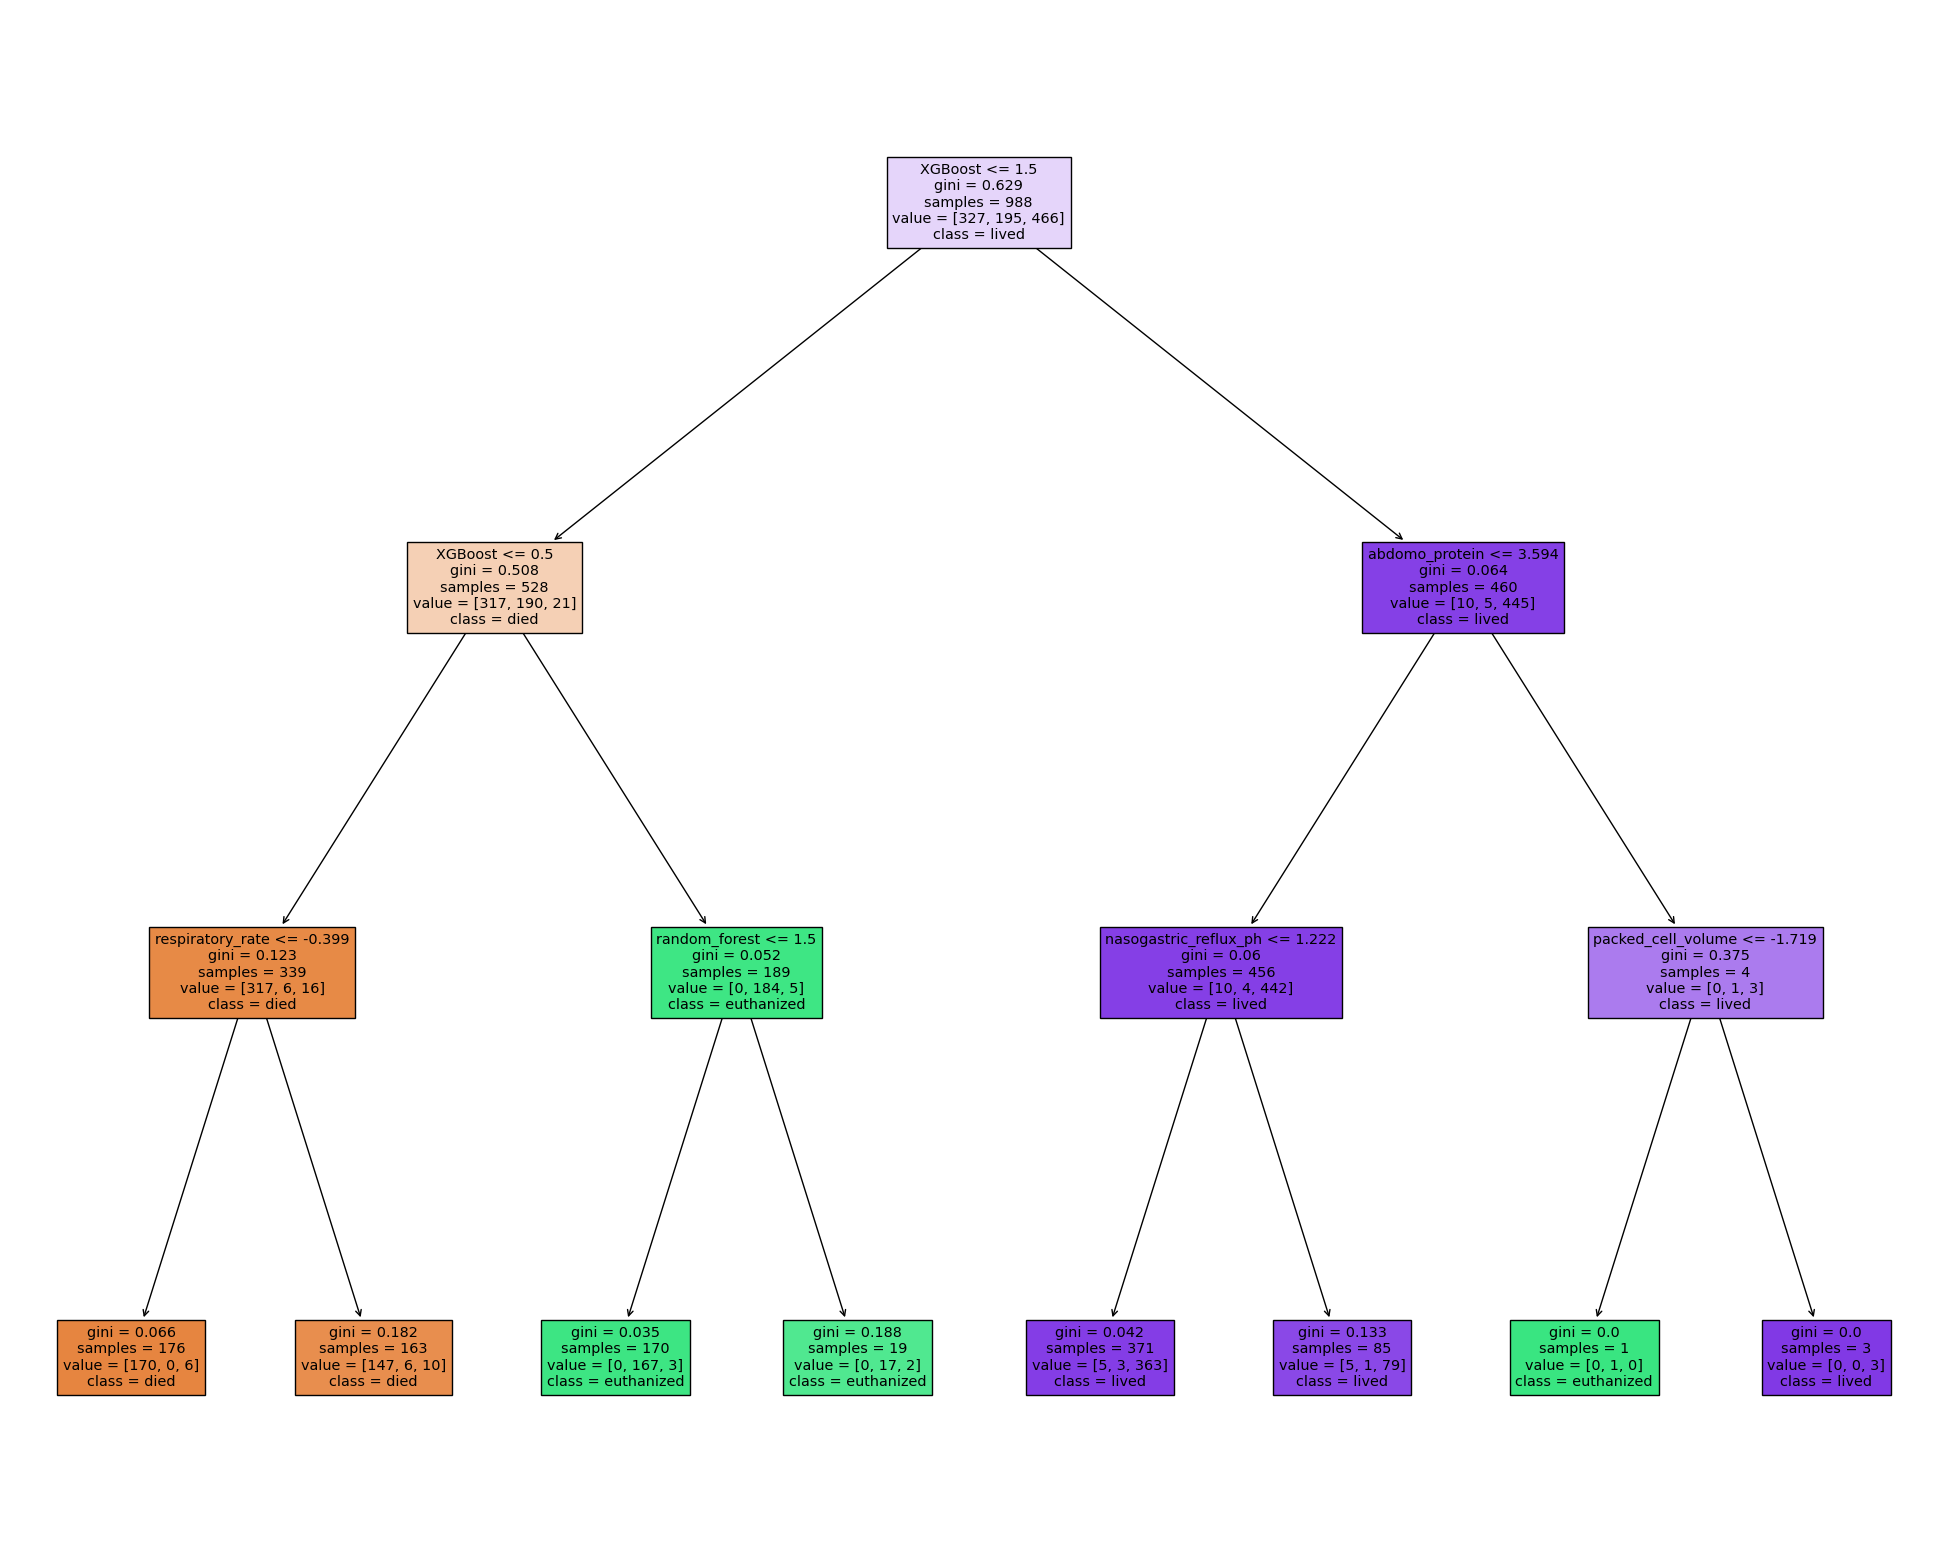

In [43]:
from sklearn import tree

FOLD_NO = 2
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_classifiers_list[FOLD_NO], 
                   feature_names=list(train_preds_dfs_list[fold_no].columns),  
                   class_names=['died', 'euthanized', 'lived'],
                   filled=True)

In [44]:
FOLD_NO = 2
test_preds = decision_tree_classifiers_list[FOLD_NO].predict(X_test_with_preds_list[FOLD_NO])

In [45]:
PRED_CATEGORIES = ['died', 'euthanized', 'lived']
pred_list = [PRED_CATEGORIES[el] for el in test_preds]

submission_df = pd.DataFrame()
df_test_raw = pd.read_csv("data/test.csv")
submission_df['id'] = df_test_raw['id']
submission_df['outcome'] = pred_list

In [46]:
submission_df.to_csv("submissions/Without_Ordinal_Encoding/K_Fold_Cross_Val/DecisionTree_Ensemble_7_RandomForest_7_43_NearestCentroid_NaiveBayes_XGBoost_LGBM_HistGB_SVC_Submission.csv", index=False)

### Custom Ensemble using XGBoost and some input columns

In [47]:
train_preds_dfs_list = []
val_preds_dfs_list = []
test_preds_dfs_list = []
for fold_no in range(len(X_train_list)):
    train_preds_df = pd.DataFrame()
    for name, model in estimator_dict.items():
        train_preds_df[name] = model[fold_no].predict(X_train_list[fold_no])

    val_preds_df = pd.DataFrame()
    for name, model in estimator_dict.items():
        val_preds_df[name] = model[fold_no].predict(X_valid_list[fold_no])

    test_preds_df = pd.DataFrame()
    for name, model in estimator_dict.items():
        test_preds_df[name] = model[fold_no].predict(X_test)
    
    train_preds_dfs_list.append(train_preds_df)
    val_preds_dfs_list.append(val_preds_df)
    test_preds_dfs_list.append(test_preds_df)


DATA_DIR = "data/Regular_Processed/Without_Ordinal_Encoding/"
train_df = pd.read_csv(os.path.join(DATA_DIR, "train_processed.csv"))
valid_df = pd.read_csv(os.path.join(DATA_DIR, "valid_processed.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test_processed.csv"))
total_df = pd.concat([train_df, valid_df], ignore_index=True)  # Verified at order is maintained

In [48]:
FEATURE_NAMES_TO_ADD = ['total_protein', 'nasogastric_reflux_ph', 'packed_cell_volume', 'abdomo_protein', 'respiratory_rate', 'pain_is_extreme_pain']
for fold_no in range(len(X_train_list)):
    for feature in FEATURE_NAMES_TO_ADD:
        train_preds_dfs_list[fold_no][feature] = total_df[feature][train_idx_list[fold_no]]
        val_preds_dfs_list[fold_no][feature] = total_df[feature][valid_idx_list[fold_no]]
        test_preds_dfs_list[fold_no][feature] = test_df[feature]

X_train_with_preds_list = [train_preds_dfs_list[fold_no].to_numpy() for fold_no in range(len(X_train_list))]
X_valid_with_preds_list = [val_preds_dfs_list[fold_no].to_numpy() for fold_no in range(len(X_train_list))]
X_test_with_preds_list = [test_preds_dfs_list[fold_no].to_numpy() for fold_no in range(len(X_train_list))]

print(f"X_train_with_preds shape: {X_train_with_preds_list[0].shape}\nX_valid_with_preds shape: {X_valid_with_preds_list[0].shape}\nX_test_with_preds shape: {X_test_with_preds_list[0].shape}")

X_train_with_preds shape: (988, 13)
X_valid_with_preds shape: (247, 13)
X_test_with_preds shape: (824, 13)


In [60]:
import xgboost as xgb

xgboost_ensemble_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_with_preds_list[fold_no]
    X_valid_fold = X_valid_with_preds_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    xgboost_classifier = xgb.XGBClassifier(n_estimators=10, max_depth=5, learning_rate=0.1, num_class=3)
    xgboost_classifier.fit(X_train_fold, y_train_fold)
    xgboost_ensemble_classifiers_list.append(xgboost_classifier)
    train_preds = xgboost_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = xgboost_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


Train F1 Scores: [0.9524291497975709, 0.9554655870445344, 0.9574898785425101, 0.9595141700404858, 0.9544534412955465]; Avg = 0.9558704453441296
Valid F1 Scores: [0.6963562753036437, 0.6761133603238867, 0.728744939271255, 0.6963562753036437, 0.7165991902834008]; Avg = 0.702834008097166
Best Fold = 2


In [61]:
FOLD_NO = 2
test_preds = xgboost_ensemble_classifiers_list[FOLD_NO].predict(X_test_with_preds_list[FOLD_NO])

In [62]:
PRED_CATEGORIES = ['died', 'euthanized', 'lived']
pred_list = [PRED_CATEGORIES[el] for el in test_preds]

submission_df = pd.DataFrame()
df_test_raw = pd.read_csv("data/test.csv")
submission_df['id'] = df_test_raw['id']
submission_df['outcome'] = pred_list

In [63]:
submission_df.to_csv("submissions/Without_Ordinal_Encoding/K_Fold_Cross_Val/XGBOOST_Ensemble_7_RandomForest_7_43_NearestCentroid_NaiveBayes_XGBoost_LGBM_HistGB_SVC_Submission.csv", index=False)